In [1]:
import tensorflow as tf
import numpy as np
import pickle
import os
import math
import skimage as ski
import skimage.io
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score


In [2]:

DATA_DIR = '/home/matija/datasets/CIFAR10'
save_dir = '/home/matija/FER/deep-learning/out/tf_cifar'
img_height = 32
img_width = 32
num_channels = 3
num_classes = 10
lr = 1e-2
batch_size = 200
loss_step = 5
draw_step = 100
acc_step = 50
max_epochs = 20
weight_decay = 1e-4

valid_size = 5000
loss_batch_size = 5000
test_batch_size = 5000


In [3]:


def to_one_hot(y, C=10):
    one_hot = [0] * C
    one_hot[y] = 1
    return one_hot


def shuffle_data(data_x, data_y):
    indices = np.arange(data_x.shape[0])
    np.random.shuffle(indices)
    shuffled_data_x = np.ascontiguousarray(data_x[indices])
    shuffled_data_y = np.ascontiguousarray(data_y[indices])
    return shuffled_data_x, shuffled_data_y


def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict


In [4]:


def load_dataset():
    train_x = np.ndarray((0, img_height * img_width *
                          num_channels), dtype=np.float32)
    train_y = []
    for i in range(1, 6):
        subset = unpickle(os.path.join(DATA_DIR, 'data_batch_%d' % i))
        train_x = np.vstack((train_x, subset['data']))
        train_y += subset['labels']
    train_x = train_x.reshape(
        (-1, num_channels, img_height, img_width)).transpose(0, 2, 3, 1)
    train_y = np.array(train_y, dtype=np.int32)

    subset = unpickle(os.path.join(DATA_DIR, 'test_batch'))
    test_x = subset['data'].reshape(
        (-1, num_channels,
         img_height, img_width)).transpose(0, 2, 3, 1).astype(np.float32)
    test_y = np.array(subset['labels'], dtype=np.int32)

    class_names = np.array(unpickle(os.path.join(
        DATA_DIR, 'batches.meta'))['label_names'])

    train_x, train_y = shuffle_data(train_x, train_y)
    valid_x = train_x[:valid_size, ...]
    valid_y = train_y[:valid_size, ...]
    train_x = train_x[valid_size:, ...]
    train_y = train_y[valid_size:, ...]
    data_mean = train_x.mean((0, 1, 2))
    data_std = train_x.std((0, 1, 2))


    train_x = (train_x - data_mean) / data_std
    valid_x = (valid_x - data_mean) / data_std
    test_x = (test_x - data_mean) / data_std

    train_x = train_x.reshape([-1, 32, 32, 3])
    valid_x = valid_x.reshape([-1, 32, 32, 3])
    test_x = test_x.reshape([-1, 32, 32, 3])
    train_y = np.array(list(map(to_one_hot, train_y)))
    test_y = np.array(list(map(to_one_hot, test_y)))
    valid_y = np.array(list(map(to_one_hot, valid_y)))

    return train_x, train_y, test_x, test_y, valid_x, valid_y, data_mean, data_std, class_names



In [5]:

def conv2d(inputs, filters, kernel_size=[5, 5], activation=tf.nn.relu,
           regularizer=tf.contrib.layers.l2_regularizer(scale=weight_decay),
           name=None):
    return tf.layers.conv2d(
        inputs=inputs,
        filters=filters,
        kernel_size=kernel_size,
        padding='same',
        activation=activation,
        kernel_regularizer=regularizer,
        name=name
    )


def max_pool(inputs, pool_size=[3, 3], strides=2, name=None):
    return tf.layers.max_pooling2d(
        inputs=inputs,
        pool_size=pool_size,
        strides=strides,
        name=name
    )


def dense(inputs, units, activation=tf.nn.relu,
          regularizer=tf.contrib.layers.l2_regularizer(scale=weight_decay),
          name=None):
    return tf.layers.dense(
        inputs=inputs,
        units=units,
        activation=activation,
        kernel_regularizer=regularizer,
        name=name
    )


In [6]:

def build_model(inputs):
    input_layer = tf.reshape(inputs, [-1, 32, 32, 3])

    conv1 = conv2d(input_layer, 16, name="conv1")
    pool1 = max_pool(conv1, name="pool1")

    conv2 = conv2d(pool1, 32, name="conv2")
    pool2 = max_pool(conv2, name="pool2")

    flat = tf.contrib.layers.flatten(pool2)

    dense1 = dense(flat, 256, name="dense1")
    dense2 = dense(dense1, 128, name="dense2")
    logits = dense(dense2, 10, activation=None,
                   regularizer=None, name="logits")

    return logits

In [7]:


def get_batches(x, y, batch_size, shuffle=True):
    indices = np.arange(x.shape[0])
    if shuffle:
        np.random.shuffle(indices)
    for i in range(0, x.shape[0] - batch_size + 1, batch_size):
        indices_range = indices[i:i + batch_size]
        yield x[indices_range], y[indices_range]


In [8]:


def draw_conv_filters(session, epoch, step, name, layer, save_dir):
    weights = session.run(tf.trainable_variables()[layer]).copy()
    num_filters = weights.shape[3]
    num_channels = weights.shape[2]
    k = weights.shape[0]
    assert weights.shape[0] == weights.shape[1]
    weights -= weights.min()
    weights /= weights.max()
    border = 1
    cols = 8
    rows = math.ceil(num_filters / cols)
    width = cols * k + (cols-1) * border
    height = rows * k + (rows-1) * border
    img = np.zeros([height, width, num_channels])
    for i in range(num_filters):
        r = int(i / cols) * (k + border)
        c = int(i % cols) * (k + border)
        img[r:r+k, c:c+k, :] = weights[:, :, :, i]
    filename = '%s_epoch_%02d_step_%06d.png' % (name, epoch, step)
    ski.io.imsave(os.path.join(save_dir, filename), img)


In [9]:

def plot_training_progress(save_dir, data):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))

    linewidth = 2
    legend_size = 10
    train_color = 'm'
    val_color = 'c'

    num_points = len(data['train_loss'])
    x_data = np.linspace(1, num_points, num_points)
    ax1.set_title('Cross-entropy loss')
    ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
             linewidth=linewidth, linestyle='-', label='train')
    ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
             linewidth=linewidth, linestyle='-', label='validation')
    ax1.legend(loc='upper right', fontsize=legend_size)
    ax2.set_title('Average class accuracy')
    ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
             linewidth=linewidth, linestyle='-', label='train')
    ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
             linewidth=linewidth, linestyle='-', label='validation')
    ax3.plot(x_data, data['lr'], marker='o', color=train_color,
             linewidth=linewidth, linestyle='-', label='learning_rate')
    ax3.legend(loc='upper left', fontsize=legend_size)

    save_path = os.path.join(save_dir, 'training_plot.pdf')
    print('Plotting in: ', save_path)
    plt.savefig(save_path)


In [10]:
train_x, train_y, test_x, test_y, valid_x, valid_y, mean, std, class_names = load_dataset()


In [11]:

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y_ = tf.placeholder(tf.int32, [None, 10])

y_conv = build_model(x)

sample_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv)

err_loss = tf.reduce_mean(sample_loss)
reg_loss = tf.losses.get_regularization_loss()

loss = err_loss + weight_decay * reg_loss

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    0.01, global_step, 500, 0.95, staircase=True)
train_step = tf.train.MomentumOptimizer(
    learning_rate, 0.9).minimize(loss, global_step=global_step)

# train_step = tf.train.GradientDescentOptimizer(lr).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)



In [12]:
num_examples = train_x.shape[0]
num_batches = num_examples // batch_size

data = {}

data['train_loss'] = []
data['valid_loss'] = []
data['train_acc'] = []
data['valid_acc'] = []
data['lr'] = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(1, max_epochs+1):
    for (i, batch) in enumerate(get_batches(train_x, train_y,
                                            batch_size)):
        train_step.run(feed_dict={
            x: batch[0],
            y_: batch[1]
        }, session=sess)
        if i % loss_step == 0:
            batch_acc, batch_loss = sess.run([accuracy, loss],
                                             feed_dict={x: batch[0],
                                                        y_: batch[1]})
            print('\repoch %d: step %d/%d, batch loss=%g, batch acc=%g' %
                  (epoch, i*batch_size, num_examples,
                   batch_loss, batch_acc), end='')
        if i % draw_step == 0:
            draw_conv_filters(
                sess, epoch, i*batch_size, "conv1", 0, save_dir
            )
    
    train_loss, train_acc = 0, 0
    did = 0
    print('\repoch %d: training loss/accuracy %d/%d' %
          (epoch, did, num_examples), end='')
    for batch in get_batches(train_x, train_y, loss_batch_size):
        batch_acc, batch_loss = sess.run([accuracy, loss],
                                         feed_dict={x: batch[0],
                                                    y_: batch[1]})
        train_acc += batch_acc
        train_loss += batch_loss

        did += loss_batch_size

        print('\repoch %d: training loss/accuracy %d/%d' %
              (epoch, did, num_examples),end='')

    train_loss /= num_examples / loss_batch_size
    train_acc /= num_examples / loss_batch_size
    
    print('\repoch %d: training loss %g, training accuracy %g' %
          (epoch, train_loss, train_acc))

    valid_acc, valid_loss = sess.run([accuracy, loss], feed_dict={
        x: valid_x,
        y_: valid_y
    })

    data['train_loss'] += [train_loss]
    data['train_acc'] += [train_acc]
    data['valid_loss'] += [valid_loss]
    data['valid_acc'] += [valid_acc]
    data['lr'] += [sess.run(learning_rate)]

    print('epoch %d: validation loss %g, validation accuracy %g' %
          (epoch, valid_loss, valid_acc))

test_acc, test_loss = 0, 0
num_test_examples = test_x.shape[0]
did = 0
print('\repoch %d: test loss/accuracy %d/%d' %
      (epoch, did, num_test_examples), end='')
for batch in get_batches(test_x, test_y, loss_batch_size):
    batch_acc, batch_loss = sess.run([accuracy, loss],
                                     feed_dict={x: batch[0],
                                                y_: batch[1]})
    test_acc += batch_acc
    test_loss += batch_loss

    did += loss_batch_size

    print('\repoch %d: test loss/accuracy %d/%d' %
          (epoch, did, num_test_examples), end='')

test_loss /= num_test_examples / loss_batch_size
test_acc /= num_test_examples / loss_batch_size

print('\repoch %d: test loss %g, test accuracy %g' %
      (epoch, test_loss, test_acc))

# plot_training_progress(save_dir, data)
# evaluate(sess, y_conv, loss, test_x, test_y, class_names)

epoch 1: step 0/45000, batch loss=2.31772, batch acc=0.105

/home/matija/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


epoch 1: training loss 1.24202, training accuracy 0.563911
epoch 1: validation loss 1.2887, validation accuracy 0.5456
epoch 2: training loss 1.01639, training accuracy 0.649933
epoch 2: validation loss 1.07736, validation accuracy 0.621
epoch 3: training loss 0.859086, training accuracy 0.701178
epoch 3: validation loss 0.956212, validation accuracy 0.6644
epoch 4: training loss 0.784381, training accuracy 0.732111
epoch 4: validation loss 0.916434, validation accuracy 0.6826
epoch 5: training loss 0.691935, training accuracy 0.758689
epoch 5: validation loss 0.885649, validation accuracy 0.6962
epoch 6: training loss 0.623936, training accuracy 0.787689
epoch 6: validation loss 0.860472, validation accuracy 0.701
epoch 7: training loss 0.569633, training accuracy 0.803756
epoch 7: validation loss 0.844402, validation accuracy 0.7096
epoch 8: training loss 0.464797, training accuracy 0.8398
epoch 8: validation loss 0.81971, validation accuracy 0.7306
epoch 9: training loss 0.411823, t

Plotting in:  /home/matija/FER/deep-learning/out/tf_cifar/training_plot.pdf


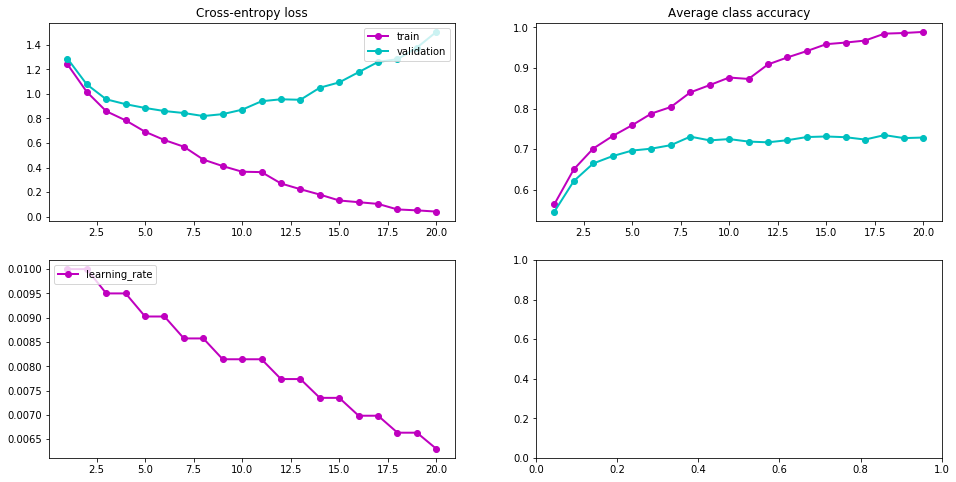

In [13]:
plot_training_progress(save_dir, data)

In [24]:
def evaluate(sess, logits, input_x, input_y, class_names):
    input_size = test_x.shape[0]
    output = np.array([])
    for batch in get_batches(test_x, test_y, test_batch_size, shuffle=False):
        batch_output = y_conv.eval(feed_dict={x: batch[0], y_: batch[1]}, session=sess)
        output = np.append(output, batch_output)
    output = output.reshape((-1, input_y.shape[1]))
    y_pred = np.asarray(np.argmax(output, 1))
    y_true = np.asarray(np.argmax(test_y, 1))

    cfm = confusion_matrix(y_true, y_pred)
    print(cfm)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    
    for (i, label) in enumerate(class_names):
        print('%s: precision %g, recall %g' % (label, precision[i], recall[i]))

In [25]:
evaluate(sess, y_conv, test_x, test_y, class_names)

[[760  13  64  16  21   6  17   7  66  30]
 [ 26 785  12   8   4   0  16   4  43 102]
 [ 58   3 642  58  88  40  67  24  11   9]
 [ 33  10  76 539  76 134  78  32   9  13]
 [ 21   2  64  46 721  19  51  60  15   1]
 [ 19   5  68 186  63 532  42  59  15  11]
 [ 14   4  36  51  46  11 820   6   9   3]
 [ 10   3  34  36  74  43   8 778   5   9]
 [ 57  14  17  10   3   1  10   7 849  32]
 [ 27  58   6  12   9   7   7  16  32 826]]
airplane: precision 0.741463, recall 0.76
automobile: precision 0.875139, recall 0.785
bird: precision 0.630029, recall 0.642
cat: precision 0.560291, recall 0.539
deer: precision 0.652489, recall 0.721
dog: precision 0.67087, recall 0.532
frog: precision 0.734767, recall 0.82
horse: precision 0.783484, recall 0.778
ship: precision 0.805503, recall 0.849
truck: precision 0.797297, recall 0.826


In [50]:
def draw_image(img, mean, std):
    img *= std
    img += mean
    img = img.astype(np.uint8)
    ski.io.imshow(img)
    ski.io.show()

In [51]:
def draw_worst(sess, sample_loss, logits, input_x, input_y, class_names, mean, std):
    input_size = test_x.shape[0]
    outputs = np.array([])
    losses = np.array([])
    for batch in get_batches(test_x, test_y, test_batch_size, shuffle=False):
        data_dict = {x: batch[0], y_: batch[1]}
        batch_output = tf.nn.softmax(logits).eval(feed_dict=data_dict, session=sess)
        batch_loss = sample_loss.eval(feed_dict=data_dict, session=sess)
        outputs = np.append(outputs, batch_output)
        losses = np.append(losses, batch_loss)
    outputs = outputs.reshape((-1, input_y.shape[1]))
    losses = losses.reshape((-1, 1))
    
    loss_idx = []
    for (i, loss) in enumerate(losses):
        loss_idx += [(i, loss)]
    loss_idx = sorted(loss_idx, key=lambda pair: pair[1], reverse=True)
    
    for (idx, _) in loss_idx[:20]:
        out = outputs[idx]
        predictions = np.argsort(-out)
        correct = np.argmax(input_y[idx])
        print("correct class: %s" % class_names[correct])
        print("predictions: %s %s" % (class_names[predictions[:3]], out[predictions[:3]]))
        draw_image(input_x[idx], mean, std)

correct class: airplane
predictions: ['horse' 'airplane' 'automobile'] [ 1.  0.  0.]


/home/matija/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


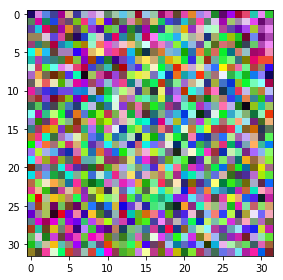

correct class: airplane
predictions: ['frog' 'cat' 'bird'] [  1.00000000e+00   1.25595578e-09   5.16265752e-10]


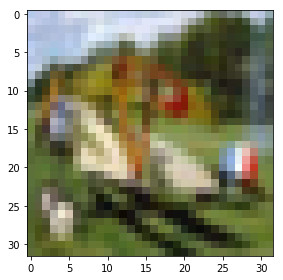

correct class: frog
predictions: ['bird' 'dog' 'cat'] [ 0.97981066  0.01850354  0.0016477 ]


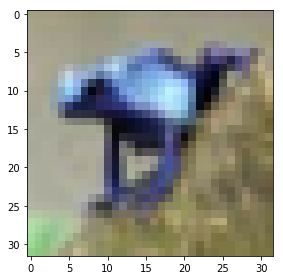

correct class: ship
predictions: ['airplane' 'truck' 'automobile'] [  9.99999881e-01   1.32716480e-07   2.31975217e-09]


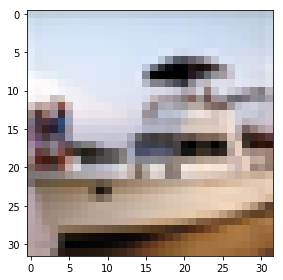

correct class: airplane
predictions: ['bird' 'frog' 'dog'] [  9.68737721e-01   3.12621407e-02   5.33141105e-08]


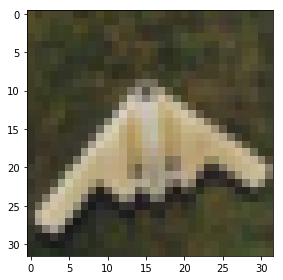

correct class: horse
predictions: ['frog' 'bird' 'cat'] [  9.99895334e-01   1.02689621e-04   1.69750024e-06]


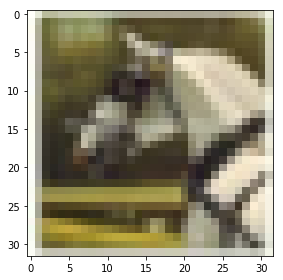

correct class: airplane
predictions: ['ship' 'frog' 'dog'] [  9.99998808e-01   1.17133993e-06   5.34710387e-10]


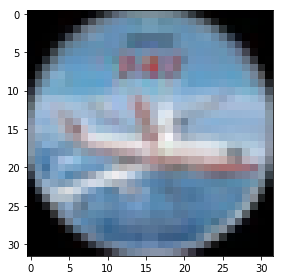

correct class: deer
predictions: ['dog' 'frog' 'cat'] [ 0.98292464  0.01541284  0.00166241]


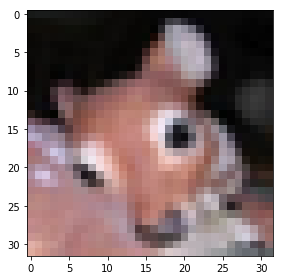

correct class: frog
predictions: ['bird' 'airplane' 'cat'] [  1.00000000e+00   4.55440707e-09   2.37712350e-10]


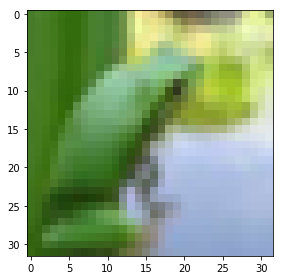

correct class: dog
predictions: ['bird' 'frog' 'deer'] [  1.00000000e+00   7.33078931e-10   1.76634291e-10]


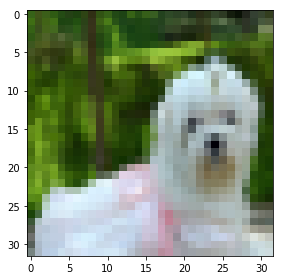

correct class: cat
predictions: ['ship' 'bird' 'automobile'] [  9.99996066e-01   3.36866447e-06   2.92733375e-07]


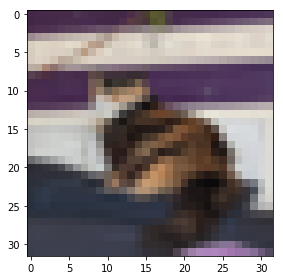

correct class: cat
predictions: ['frog' 'bird' 'cat'] [  1.00000000e+00   7.99406374e-11   6.68303676e-11]


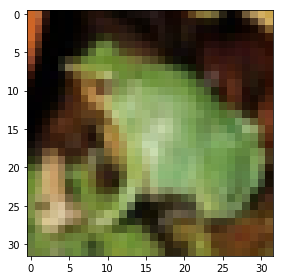

correct class: automobile
predictions: ['airplane' 'truck' 'deer'] [  9.99999642e-01   1.87413107e-07   6.84709036e-08]


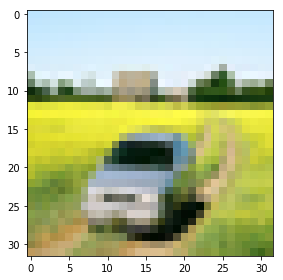

correct class: bird
predictions: ['dog' 'cat' 'horse'] [  9.98261034e-01   1.68920017e-03   4.81144052e-05]


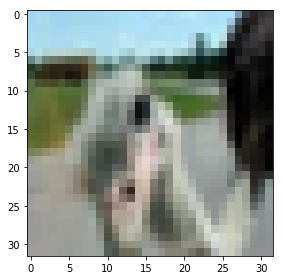

correct class: dog
predictions: ['airplane' 'bird' 'automobile'] [  9.98875797e-01   9.68663895e-04   1.54758178e-04]


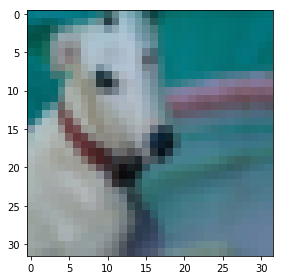

correct class: ship
predictions: ['frog' 'deer' 'bird'] [  9.85318422e-01   1.39179211e-02   7.49078579e-04]


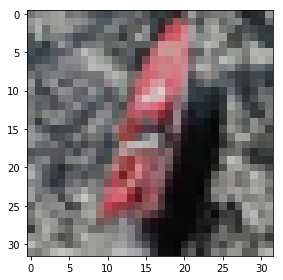

correct class: dog
predictions: ['airplane' 'deer' 'horse'] [  9.99998689e-01   1.27789951e-06   2.08937689e-09]


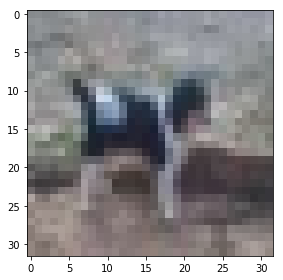

correct class: bird
predictions: ['deer' 'horse' 'cat'] [  7.93232977e-01   2.06763655e-01   2.14375382e-06]


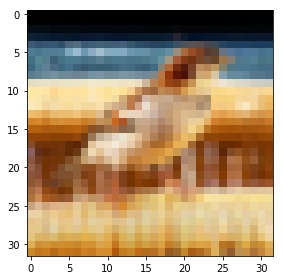

correct class: cat
predictions: ['frog' 'deer' 'dog'] [  9.99609172e-01   3.18818697e-04   7.07012878e-05]


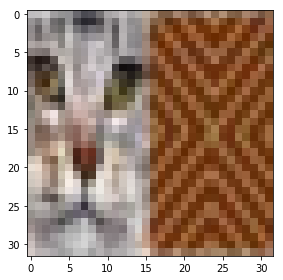

correct class: horse
predictions: ['deer' 'bird' 'dog'] [  9.99788344e-01   2.10937185e-04   7.71822329e-07]


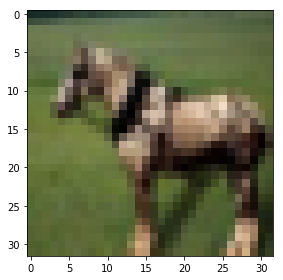

In [52]:
draw_worst(sess, sample_loss, y_conv, test_x, test_y, class_names, mean, std)